In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.wkb import loads
from library.lib_aws import PostgresRDS
from library import lib_dyna
import matplotlib.pyplot as plt
import seaborn as sns
from pyefd import reconstruct_contour

from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Data Selection

Data is selected for Well **Cook 12-13 6B** between the Dates **2019-03-19** and **2020-05-26**.

Following Columns are selected:
- NodeID
- Date
- pocdowncard

After querying `pocdowncard` is in a WKB format. This will be converted to a Shapely Polygon Object using the `shapely.wkb.loads` method

In [3]:
well_name = 'Cook 12-13 6B'

query = """
SELECT 
    "NodeID",
    "Date",
    "pocdowncard",
    "Fillage",
    "SPM"
FROM
    xspoc.card
WHERE
    "NodeID" = '{}' AND
    "Date" BETWEEN '2018-03-19' AND '2020-05-26'
""".format(well_name)

with PostgresRDS(db='oasis-dev') as engine:
    data = pd.read_sql(query, engine, parse_dates=['Date'])
    
print("\nData before converting")
data.dropna(inplace=True)  # Nans arent present, but if they are will have to be dropped
display(data.head())

# COnverting the card data
data.pocdowncard = data.pocdowncard.apply(lambda x: loads(x, hex=True))
print("Data after converting")
display(data.head())

Connected to oasis-dev DataBase
Connection Closed

Data before converting


,NodeID,Date,pocdowncard,Fillage,SPM
0,Cook 12-13 6B,2019-03-19 00:12:48,010300000001000000640000000000008014AE16400000...,94.8,3.1
1,Cook 12-13 6B,2019-03-19 00:55:33,01030000000100000064000000000000608FC219400000...,44.9,1.4
2,Cook 12-13 6B,2019-03-19 02:52:18,0103000000010000006400000000000060B81E05400000...,49.4,1.4
3,Cook 12-13 6B,2019-03-19 03:09:29,0103000000010000006400000000000040E17A14400000...,98.4,3.1
4,Cook 12-13 6B,2019-03-19 04:20:22,01030000000100000064000000000000C0CCCC0E400000...,52.8,1.4


Data after converting


,NodeID,Date,pocdowncard,Fillage,SPM
0,Cook 12-13 6B,2019-03-19 00:12:48,"POLYGON ((5.670000076293945 -9814, 15.43000030...",94.8,3.1
1,Cook 12-13 6B,2019-03-19 00:55:33,"POLYGON ((6.440000057220459 -8749, 15.72000026...",44.9,1.4
2,Cook 12-13 6B,2019-03-19 02:52:18,"POLYGON ((2.640000104904175 -9096, 10.68999958...",49.4,1.4
3,Cook 12-13 6B,2019-03-19 03:09:29,"POLYGON ((5.119999885559082 -10034, 14.3500003...",98.4,3.1
4,Cook 12-13 6B,2019-03-19 04:20:22,"POLYGON ((3.849999904632568 -9043, 13.32999992...",52.8,1.4


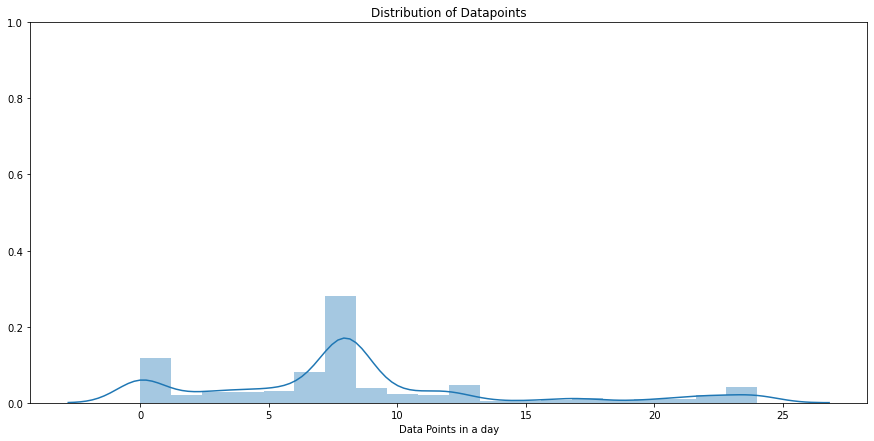

In [4]:
"""
Identifying Number of Cards Present in a Day
"""
grouper = data.set_index('Date').groupby(pd.Grouper(freq='1D'))
grp = grouper['pocdowncard'].count()

# plt.rcParams['axes.facecolor']='w'
plt.figure(figsize=(15, 7)) 
sns.distplot(grp.values, bins=20)
plt.xlabel('Data Points in a day')
plt.title("Distribution of Datapoints")
ax = plt.gca()
ax.set_ylim(0,1)
fig = plt.gcf()
fig.patch.set_facecolor('w')
plt.show()

In [5]:
print("Avergae Time diff between 2 cards: {}".format(data.Date.diff().apply(lambda t: t.round(freq='H')).dropna().mean()))

t_dff = data.Date.diff().apply(lambda t: t.round(freq='H')).dropna().value_counts()

print("-----\nTime Differnece Value Counts Between cards")
display(t_dff)

Avergae Time diff between 2 cards: 0 days 02:50:51.438053
-----
Time Differnece Value Counts Between cards


0 days 03:00:00     1568
0 days 02:00:00      835
0 days 00:00:00      565
0 days 01:00:00      426
0 days 04:00:00       59
0 days 06:00:00       51
0 days 05:00:00       14
0 days 08:00:00       14
0 days 09:00:00       11
1 days 03:00:00       10
0 days 10:00:00        9
0 days 07:00:00        8
0 days 12:00:00        7
0 days 18:00:00        5
1 days 02:00:00        4
0 days 16:00:00        4
0 days 15:00:00        3
1 days 01:00:00        2
1 days 09:00:00        2
0 days 21:00:00        2
1 days 04:00:00        2
1 days 16:00:00        1
39 days 22:00:00       1
3 days 07:00:00        1
0 days 11:00:00        1
7 days 00:00:00        1
1 days 05:00:00        1
0 days 22:00:00        1
0 days 13:00:00        1
0 days 14:00:00        1
1 days 20:00:00        1
1 days 22:00:00        1
2 days 18:00:00        1
1 days 23:00:00        1
4 days 00:00:00        1
1 days 00:00:00        1
Name: Date, dtype: int64

### Generating Features for forecasting

**Logic Used:**

**Variables:** 

window --> No of timestamps used for forecasting

n -->  No of timesteps forecasted

delta --> Time Delta within which the window and n at a minimum shoul lie. This accounts for variable frequencies of cards in a specific day

*Note: Using a delta like this will not completely account for the varibale time differnece between cards.* 

*Once the frequecy between cards is constant, time-delta can be a function of window and n*

**Steps**
- Iterate over each index (Timestamp)
- For a specicif t (timestamp), identify the values lying within a delta (t + delta) 
- Check if atleast a minimum of (window + n) no of samples lie in this time chunk.
- If it does:
    - Append the xt and the yt values
    - xt will be all the features between t and window
    - yt will be all features betweent winow and n
- If does not meet the requirements dont consider those features.


In [6]:
def forecast_features(ts, window, n, delta, non_fd=False):
    """
    Creates a forecasting matirx of X and Y
    The shape of X is no_of_samples * window * Number of features
    The shape of y is no_of_samples * timesteps_forecasted * Number of features
    :param ts: TImesereies being forecasted. Timestamps as the index and features as the columns
    :param window: The window for prediction (No of timesteps to use for predictions)
    :param n: The number of timesteps forecasted
    :param delta: The time delta used for selecting continuous timesteps
    :param non_fd: Non FD Features. Columns should be at the end
    """
    
    X = []  # Initialize feature Matrix
    y = []  # Initialize labels
    time_ind = []
    c = 0  # Counter to see how many data points were dropped
    delta = pd.Timedelta(delta)
    for t in ts.index:
        time_chunk = ts[t: t+delta]  # Get the chunk of time from the time delta
        if time_chunk.shape[0] >= (window + n):  # Need to have atleast window + n of data points in the time chunk
            X.append(time_chunk.iloc[0: window].values)
            if non_fd:
                y.append(time_chunk.iloc[window: window+n,:-non_fd].values)
            else:
                y.append(time_chunk.iloc[window: window+n].values)
            time_ind.append(time_chunk.iloc[window: window+n].index)
        else:
            c+=1

    print("No. of datapoints discarded {}".format(c))
    X = np.array(X)
    y = np.array(y)
    time_ind = np.array(time_ind)
    
    return X, y, time_ind
    


**Deciding on delta:**

- We have, at an average, every data every 3H
- At minimum we need, widow + n inside the delta we choose
- For a window of 5 and n of 1 an approx of the delta will be
    - delta = (window + n) * 3 + 1
    - delta = (5 + 1) * 3 + 1 = 19


### Feature Generation

In [7]:
"""
Method 1
Using the Features Class in lib_dyna
Will have to convert it back into a dataframe with Date as the index
"""

fea = lib_dyna.Features(df=data,
                        well_col='NodeID',
                       card_col='pocdowncard')

In [8]:
fd_order = 5

In [9]:
fea.remove_errors()  # Removes all data points where fd cant be found
bounds = fea.all_bounds()  # Can be used to normalize in a well specific min-max
# clean_df = fea.df  # If shape is same as data dont have to run remove errors
fd = fea.get_X(fd_order=fd_order, area=False, centroid=False, normalize_fn='df', norm_arg=bounds)

if fd.shape[0] != data.shape[0]:
    data = fea.df  # some data points were removed as errors, we need clean data as data

fd_df = pd.DataFrame(index = data.Date, data = fd)

print("FD Matrix")
fd_df.head()

Total errors found in 0 datapoints
FD Matrix


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2019-03-19 00:12:48,-0.288901,0.259571,-0.268508,-0.261953,0.001880,-0.009000,-0.005704,0.009348,-0.027704,-0.024360,-0.037139,0.032056,-0.000306,-0.000613,0.000123,-0.003124,-0.010450,0.012112,-0.012711,-0.012816
2019-03-19 00:55:33,-0.264557,0.150317,-0.296912,-0.157263,0.061512,0.014319,-0.055591,-0.032235,-0.042656,0.020647,-0.002321,-0.006978,-0.014275,-0.012902,0.012284,0.000243,-0.008830,0.006474,-0.010996,-0.003993
2019-03-19 02:52:18,-0.251294,0.158126,-0.312700,-0.159757,0.059592,0.014965,-0.049427,-0.027636,-0.047991,0.017283,-0.000858,-0.004668,-0.015515,-0.013992,0.010950,0.001925,-0.007831,0.005381,-0.012373,-0.001674
2019-03-19 03:09:29,-0.282435,0.268266,-0.288111,-0.272145,-0.001138,-0.013308,-0.006128,0.013534,-0.029025,-0.027490,-0.033637,0.031157,0.000064,0.002120,-0.000844,-0.004462,-0.009056,0.011122,-0.015686,-0.013025
2019-03-19 04:20:22,-0.248752,0.162862,-0.317136,-0.177195,0.059210,0.019797,-0.050327,-0.031273,-0.054940,0.014986,0.002340,-0.002310,-0.014418,-0.015732,0.011161,0.002782,-0.005589,0.005656,-0.014577,-0.003646


In [10]:
fd_df.isnull().sum(axis=0)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
dtype: int64

In [11]:
"""
Adding Features from the dataset
For area and centroid will be added from the get_X function used above
"""
add_extra_features = False

if add_extra_features:
    feature_df = pd.concat([fd_df, data.set_index("Date").reindex(fd_df.index)[['Fillage', 'SPM']]], axis=1)  # Specifiy the columns from the dataset
else:
    feature_df = fd_df.copy()
    
feature_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2019-03-19 00:12:48,-0.288901,0.259571,-0.268508,-0.261953,0.001880,-0.009000,-0.005704,0.009348,-0.027704,-0.024360,-0.037139,0.032056,-0.000306,-0.000613,0.000123,-0.003124,-0.010450,0.012112,-0.012711,-0.012816
2019-03-19 00:55:33,-0.264557,0.150317,-0.296912,-0.157263,0.061512,0.014319,-0.055591,-0.032235,-0.042656,0.020647,-0.002321,-0.006978,-0.014275,-0.012902,0.012284,0.000243,-0.008830,0.006474,-0.010996,-0.003993
2019-03-19 02:52:18,-0.251294,0.158126,-0.312700,-0.159757,0.059592,0.014965,-0.049427,-0.027636,-0.047991,0.017283,-0.000858,-0.004668,-0.015515,-0.013992,0.010950,0.001925,-0.007831,0.005381,-0.012373,-0.001674
2019-03-19 03:09:29,-0.282435,0.268266,-0.288111,-0.272145,-0.001138,-0.013308,-0.006128,0.013534,-0.029025,-0.027490,-0.033637,0.031157,0.000064,0.002120,-0.000844,-0.004462,-0.009056,0.011122,-0.015686,-0.013025
2019-03-19 04:20:22,-0.248752,0.162862,-0.317136,-0.177195,0.059210,0.019797,-0.050327,-0.031273,-0.054940,0.014986,0.002340,-0.002310,-0.014418,-0.015732,0.011161,0.002782,-0.005589,0.005656,-0.014577,-0.003646


In [12]:
extra_features = 0  # If any extra features have been added after fd. These features should be at the end

"""
Scale the fd and the extra features separately
"""

if extra_features != 0:
    scaler_fd = StandardScaler()  # Only use for scaling fd features
    scaler_extra = StandardScaler()  # For scaling any other features

    f1 = scaler_fd.fit_transform(feature_df.iloc[:, 0:-extra_features])
    f2 = scaler_extra.fit_transform(feature_df.iloc[:,-extra_features:])

    feature_df = pd.DataFrame(index=feature_df.index, data=(np.hstack([f1, f2])))

    display(feature_df.head())
else:
    scaler_fd = StandardScaler()
    f1 = scaler_fd.fit_transform(feature_df)
    feature_df = pd.DataFrame(index=feature_df.index, data = f1)
    display(feature_df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2019-03-19 00:12:48,-0.722832,0.778413,0.510751,-0.579775,-0.903617,-1.331739,0.670819,1.266148,0.899311,-0.987169,-1.339253,1.363506,0.668203,0.949885,-0.912529,-0.480415,-0.941544,0.936388,0.227100,-1.007384
2019-03-19 00:55:33,0.123257,-1.417411,0.002290,1.277709,1.474420,0.789389,-1.244553,-0.773397,-0.206684,1.252549,0.824352,-1.397859,-1.223121,-0.688133,1.413849,0.193302,-0.617087,-0.399546,0.517505,0.424159
2019-03-19 02:52:18,0.584197,-1.260462,-0.280332,1.233472,1.397874,0.848137,-1.007890,-0.547812,-0.601258,1.085167,0.915247,-1.234421,-1.390977,-0.833388,1.158564,0.529843,-0.417098,-0.658357,0.284330,0.800473
2019-03-19 03:09:29,-0.498121,0.953171,0.159833,-0.760606,-1.024009,-1.723591,0.654513,1.471465,0.801587,-1.142956,-1.121638,1.299912,0.718227,1.314295,-1.097453,-0.748162,-0.662285,0.701648,-0.276864,-1.041352
2019-03-19 04:20:22,0.672560,-1.165273,-0.359752,0.924062,1.382627,1.287604,-1.042421,-0.726221,-1.115317,0.970834,1.113965,-1.067609,-1.242433,-1.065258,1.199010,0.701447,0.031980,-0.593375,-0.088952,0.480378


In [13]:
"""
Transforming features into forecasting features
"""
future_pred_no = 1  # For now the predictions and models havent been automated to use any number here, only works for 2. if chenged,codes further ahead need to be changed manually


X, Y, T = forecast_features(ts=feature_df, window=6, n=future_pred_no, delta='24H', non_fd=extra_features)  # 5 timesteps to predict the next 2 in a 22H delta

print("Shape of x")
print(np.shape(X))

print("\nShape of y")
print(np.shape(Y))

No. of datapoints discarded 301
Shape of x
(3316, 6, 20)

Shape of y
(3316, 1, 20)


In [14]:
"""
Isolating future predictions
Using 2 as 2 time stemps being predicted ahead
"""
Y1 = Y[:,0,:]
# Y2 = Y[:,1,:]

In [15]:
"""
Splitting our data
"""
# Sizes
sample_size = X.shape[0]  # Full sample size
train_size = int(sample_size*0.8)  # Train size
val_size = int(sample_size*0.1)  # validation Size
test_size = sample_size - train_size - val_size  # Test Size

# Feature Matrix
x_train = X[0:train_size]
x_val = X[train_size: train_size+val_size]
x_test = X[train_size+val_size:sample_size]

# Label Matrix
# 1st timestep
y_train1 = Y1[0:train_size]
y_val1 = Y1[train_size: train_size+val_size]
y_test1 = Y1[train_size+val_size:sample_size]

# # 2nd timestep
# y_train2 = Y2[0:train_size]
# y_val2 = Y2[train_size: train_size+val_size]
# y_test2 = Y2[train_size+val_size:sample_size]

# Timestamps
t_train = T[0:train_size]
t_val = T[train_size: train_size+val_size]
t_test = T[train_size+val_size:sample_size]

## LSTM

Using the test LSTM from the code `LSTM - Oasis`. To see if the feature matrix dimensions are correct

In [16]:
import keras 

In [21]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

## Model 1

1 Timestamp ahead prediction

In [18]:
keras.backend.clear_session()
model1 = Sequential()
model1.add(GRU(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True, activation = 'relu'))
model1.add(GRU(100, activation = 'relu', return_sequences=True))
# model1.add(LSTM(80, activation = 'relu'))
model1.add(Dense(y_train1.shape[1]))
model1.compile(loss='mse', optimizer='adam', metrics=['mse','accuracy'])

# Fit the LSTM Model
history1 = model1.fit(x_train, y_train1, 
                    epochs=100,   
                    validation_data=(x_val,y_val1),
                    verbose=1)

Epoch 1/100
83/83 [==============================] - 1s 18ms/step - loss: 0.8276 - mse: 0.8276 - accuracy: 0.1572 - val_loss: 0.8809 - val_mse: 0.8809 - val_accuracy: 0.0030
Epoch 2/100
83/83 [==============================] - 1s 13ms/step - loss: 0.7590 - mse: 0.7590 - accuracy: 0.2202 - val_loss: 0.7914 - val_mse: 0.7914 - val_accuracy: 0.3172
Epoch 3/100
83/83 [==============================] - 1s 13ms/step - loss: 0.7456 - mse: 0.7456 - accuracy: 0.2146 - val_loss: 0.7590 - val_mse: 0.7590 - val_accuracy: 0.4199
Epoch 4/100
83/83 [==============================] - 1s 13ms/step - loss: 0.7083 - mse: 0.7083 - accuracy: 0.2315 - val_loss: 0.8269 - val_mse: 0.8269 - val_accuracy: 0.4109
Epoch 5/100
83/83 [==============================] - 1s 13ms/step - loss: 0.6681 - mse: 0.6681 - accuracy: 0.2640 - val_loss: 0.8083 - val_mse: 0.8083 - val_accuracy: 0.2659
Epoch 6/100
83/83 [==============================] - 1s 13ms/step - loss: 0.6573 - mse: 0.6573 - accuracy: 0.2704 - val_loss: 0.78

In [19]:
accr_test = model1.evaluate(x_test, y_test1)
print('Test set\n  Loss: {:0.3f}\n  mae: {:0.3f}, \n  Accuracy: {:0.3f}'.format(accr_test[0],
                                                                                accr_test[1],
                                                                                accr_test[2]))

accr_train = model1.evaluate(x_train, y_train1)
print('Train set\n  Loss: {:0.3f}\n  mae: {:0.3f}, \n  Accuracy: {:0.3f}'.format(accr_train[0],
                                                                                 accr_train[1],
                                                                                 accr_train[2]))

11/11 [==============================] - 0s 4ms/step - loss: 1.1608 - mse: 1.1608 - accuracy: 0.3243
Test set
  Loss: 1.161
  mae: 1.161, 
  Accuracy: 0.324
83/83 [==============================] - 0s 5ms/step - loss: 0.0619 - mse: 0.0619 - accuracy: 0.6433
Train set
  Loss: 0.062
  mae: 0.062, 
  Accuracy: 0.643


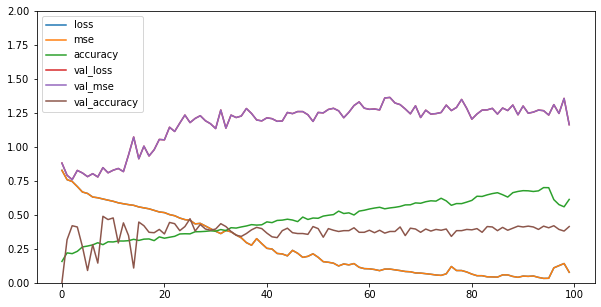

In [20]:
pd.DataFrame(history1.history).plot(figsize=(10,5))
# plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

## Model 2

2 Timestep prediction

In [22]:
model2 = Sequential()
model2.add(LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True, activation = 'relu'))
model2.add(LSTM(100, activation = 'relu', return_sequences=True))
model2.add(LSTM(80, activation = 'relu'))
model2.add(Dense(y_train2.shape[1]))
model2.compile(loss='mse', optimizer='adam', metrics=['mse','accuracy'])

# Fit the LSTM Model
history2 = model2.fit(x_train, y_train2, 
                    epochs=100,   
                    validation_data=(x_val,y_val2),
                    verbose=1)

Epoch 1/100
81/81 [==============================] - 1s 18ms/step - loss: 0.8465 - mse: 0.8465 - accuracy: 0.0804 - val_loss: 0.9787 - val_mse: 0.9787 - val_accuracy: 0.0031
Epoch 2/100
81/81 [==============================] - 1s 13ms/step - loss: 0.7926 - mse: 0.7926 - accuracy: 0.1472 - val_loss: 0.7707 - val_mse: 0.7707 - val_accuracy: 0.2000
Epoch 3/100
81/81 [==============================] - 1s 12ms/step - loss: 0.7793 - mse: 0.7793 - accuracy: 0.1390 - val_loss: 0.8025 - val_mse: 0.8025 - val_accuracy: 0.3250
Epoch 4/100
81/81 [==============================] - 1s 12ms/step - loss: 0.7672 - mse: 0.7672 - accuracy: 0.1675 - val_loss: 0.8233 - val_mse: 0.8233 - val_accuracy: 0.2750
Epoch 5/100
81/81 [==============================] - 1s 11ms/step - loss: 0.7640 - mse: 0.7640 - accuracy: 0.1843 - val_loss: 0.7561 - val_mse: 0.7561 - val_accuracy: 0.4094
Epoch 6/100
81/81 [==============================] - 1s 11ms/step - loss: 0.7521 - mse: 0.7521 - accuracy: 0.1820 - val_loss: 0.78

In [23]:
accr_test = model2.evaluate(x_test, y_test2)
print('Test set\n  Loss: {:0.3f}\n  mae: {:0.3f}, \n  Accuracy: {:0.3f}'.format(accr_test[0],
                                                                                accr_test[1],
                                                                                accr_test[2]))

accr_train = model2.evaluate(x_train, y_train2)
print('Train set\n  Loss: {:0.3f}\n  mae: {:0.3f}, \n  Accuracy: {:0.3f}'.format(accr_train[0],
                                                                                 accr_train[1],
                                                                                 accr_train[2]))

11/11 [==============================] - 0s 4ms/step - loss: 0.9339 - mse: 0.9339 - accuracy: 0.2555
Test set
  Loss: 0.934
  mae: 0.934, 
  Accuracy: 0.255
81/81 [==============================] - 0s 5ms/step - loss: 0.0326 - mse: 0.0326 - accuracy: 0.6958
Train set
  Loss: 0.033
  mae: 0.033, 
  Accuracy: 0.696


## Predictions and Plots

Features

x_test, y_test1, y_test2  -- Test

x_val, y_val1, y_val2 -- Validation

x_train, y_train1, y_train2 -- Training

In [24]:
"""
1 Timestamp Ahead Prediction
"""

# Predicted Values
y_pred1 = model1.predict(x_test)
y_pred1 = scaler_fd.inverse_transform(y_pred1)
y_pred_df1 = pd.DataFrame(y_pred1)  # predicted DF

# True Values
y_true_df1 = pd.DataFrame(scaler_fd.inverse_transform(y_test1))  # True df


"""
2 Timestamp Ahead Prediction
"""

# Predicted Values
y_pred2 = model2.predict(x_test)
y_pred2 = scaler_fd.inverse_transform(y_pred2)
y_pred_df2 = pd.DataFrame(y_pred2)  # predicted DF

# True Values
y_true_df2 = pd.DataFrame(scaler_fd.inverse_transform(y_test2))  # True df

In [25]:
print("Total Data points in the test set:")
print(y_true_df1.shape[0])

Total Data points in the test set:
321


Date of Card being predicted
2020-03-06 20:41:54


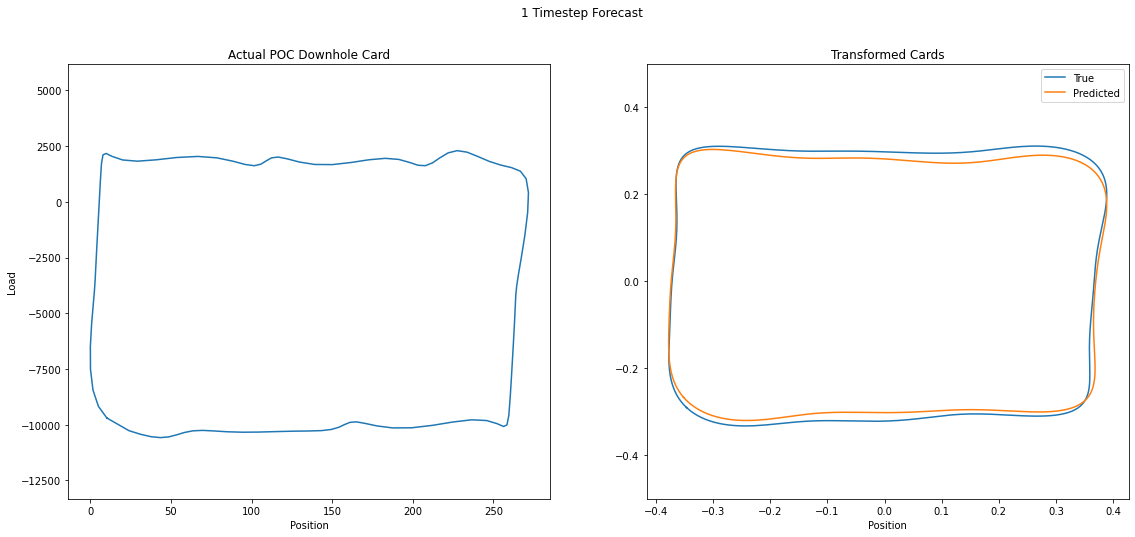

In [28]:
from time import sleep
"""
PLotting 1 Time step
"""

index = 100

# True
fd_true1 = y_true_df1.loc[index].values.reshape(fd_order,4)
true_xy1 = reconstruct_contour(fd_true1)

# Predicted
fd_pred1 = y_pred_df1.loc[index].values.reshape(fd_order,4)
pred_xy1 = reconstruct_contour(fd_pred1)

# Actual Card before fd
t1 = t_test[index][0]  # zero as we are checking for the 1 timestamp ahead
print("Date of Card being predicted")
print(pd.to_datetime(t1))
poly1 = data.loc[data.Date == t1, 'pocdowncard'].values[0]
real_xy1 = np.asarray(poly1.exterior.coords)

"""
Plot
"""
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(19,8))

ax1.plot(real_xy1[:,0], real_xy1[:,1], label='POC DownHole Card')
# ax1.legend(loc='best')
# ax1.set_ylim((tuple(bounds.iloc[:,0].values[2:])))
ax1.set_ylim((tuple((bounds-1000).iloc[:,0].values[2:])))
#     ax1.set_ylim((-13000, 4000))
ax1.set_ylabel('Load')
ax1.set_xlabel('Position')
ax1.set_title('Actual POC Downhole Card')

ax2.plot(true_xy1[:,0], true_xy1[:,1], label='True')
ax2.plot(pred_xy1[:,0], pred_xy1[:,1], label='Predicted')
ax2.set_ylim((-0.5,0.5))
ax2.legend(loc='best')
ax2.set_xlabel('Position')
ax2.set_title('Transformed Cards')

fig.patch.set_facecolor('w')
fig.suptitle('1 Timestep Forecast')
plt.show()
plt.close()

Date of card being predicted:
2020-03-06 23:42:21


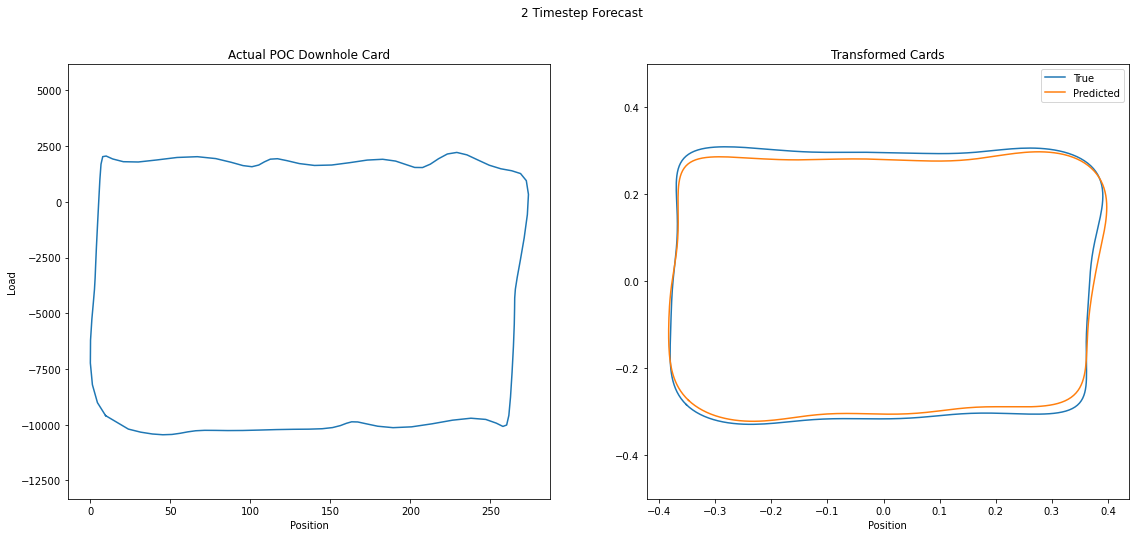

In [29]:
"""
2 Timestamps Ahead
"""
# True
fd_true2 = y_true_df2.loc[index].values.reshape(fd_order,4)
true_xy2 = reconstruct_contour(fd_true2)

# Predicted
fd_pred2 = y_pred_df2.loc[index].values.reshape(fd_order,4)
pred_xy2 = reconstruct_contour(fd_pred2)

# Actual Card before fd
t2 = t_test[index][1]  # zero as we are checking for the 1 timestamp ahead
print("Date of card being predicted:")
print(pd.to_datetime(t2))
poly2 = data.loc[data.Date == t2, 'pocdowncard'].values[0]
real_xy2 = np.asarray(poly2.exterior.coords)

"""
Plot Steps
"""

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(19,8))

ax1.plot(real_xy2[:,0], real_xy2[:,1], label='POC DownHole Card')
# ax1.legend(loc='best')
""""""
# ax1.set_ylim((tuple(bounds.iloc[:,0].values[2:])))
ax1.set_ylim((tuple((bounds-1000).iloc[:,0].values[2:])))
""""""

ax1.set_ylabel('Load')
ax1.set_xlabel('Position')
ax1.set_title('Actual POC Downhole Card')

ax2.plot(true_xy2[:,0], true_xy2[:,1], label='True')
ax2.plot(pred_xy2[:,0], pred_xy2[:,1], label='Predicted')
ax2.set_ylim((-0.5,0.5))
ax2.legend(loc='best')
ax2.set_xlabel('Position')
ax2.set_title('Transformed Cards')

fig.patch.set_facecolor('w')
fig.suptitle('2 Timestep Forecast')
plt.show()



In [233]:
pd.to_datetime(t2)

Timestamp('2020-03-21 18:07:41')